# Preprocessing the `sci-Plex 3`  perturbation dataset


The data was generated by Srivatsan et al. [[1]](https://www.science.org/doi/10.1126/science.aax6234)
and consists of three cancer cell lines (A549, MCF7, K562) treated with 188 different compounds with different mechanisms of action. 
The cells are treated with 4 different dosages (10, 100, 1000, and 10000 nM) plus control.

Data was downloaded from Hetzel et Al. [[2]](https://openreview.net/forum?id=vRrFVHxFiXJ), [`sciplex_complete_middle_subset.h5ad`](https://f003.backblazeb2.com/file/chemCPA-datasets/sciplex_complete_middle_subset.h5ad) and processed as detailed below.

[[1] Srivatsan, S. R., McFaline-Figueroa, J. L., Ramani, V., Saunders, L., Cao, J., Packer, J., ... & Trapnell, C. (2020). Massively multiplex chemical transcriptomics at single-cell resolution. Science, 367(6473), 45-51.](https://www.science.org/doi/10.1126/science.aax6234)

[[2] Hetzel, Leon, Simon Böhm, Niki Kilbertus, Stephan Günnemann, Mohammad Lotfollahi, and Fabian Theis. "Predicting Cellular Responses to Novel Drug Perturbations at a Single-Cell Resolution" Advances in Neural Information Processing Systems (2022).](https://openreview.net/forum?id=vRrFVHxFiXJ)


## load packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

In [3]:
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import re
import chemprop
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
sys.path.append("../../../")
sys.path.append("../../../utils/")
from paths import DATA_DIR, FIG_DIR

In [5]:
from utils.parameters_sciplex3 import ood_drugs, validation_drugs, groups, groups_colors

## Set parameters

In [6]:
import mplscience

mplscience.set_style()

plt.rcParams["legend.scatterpoints"] = 1

In [7]:
DATA_DIR_LCL = str(DATA_DIR) + "/perturbations/sciplex3/"
FIG_DIR_LCL = str(FIG_DIR) + "/perturbations/sciplex3/"

## Process data


Using pre-processed `adata` file by [[1]](https://openreview.net/forum?id=vRrFVHxFiXJ), [`sciplex_complete_middle_subset.h5ad`](https://f003.backblazeb2.com/file/chemCPA-datasets/sciplex_complete_middle_subset.h5ad) or [`sciplex_complete_middle_subset_lincs_genes`](https://f003.backblazeb2.com/file/chemCPA-datasets/sciplex_complete_middle_subset_lincs_genes.h5ad).

We add `rdkit2d` features and `split_ood` based on the 9 drugs reported in [[1]]().


[[1] Hetzel, Leon, Simon Böhm, Niki Kilbertus, Stephan Günnemann, Mohammad Lotfollahi, and Fabian Theis. "Predicting Cellular Responses to Novel Drug Perturbations at a Single-Cell Resolution" Advances in Neural Information Processing Systems (2022).](https://openreview.net/forum?id=vRrFVHxFiXJ)



In [8]:
adata = sc.read(
    DATA_DIR_LCL + "sciplex_complete_middle_subset.h5ad",
    backup_url="https://f003.backblazeb2.com/file/chemCPA-datasets/sciplex_complete_middle_subset.h5ad",
)

In [9]:
features = {}
for mol in adata.obs["SMILES"].cat.categories:
    features[
        mol
    ] = chemprop.features.features_generators.rdkit_2d_normalized_features_generator(
        mol
    )

features_arr = np.asarray([features[mol] for mol in features])

In [10]:
features_df = pd.DataFrame.from_dict(features).T
features_df = features_df.fillna(0)

In [11]:
threshold = 0.001
cols_keep = list(np.where(features_df.std() > threshold)[0])
features_df = features_df.iloc[:, np.where(features_df.std() > threshold)[0]]

In [12]:
normalized_df = (features_df - features_df.mean()) / features_df.std()

In [13]:
features_cells = np.zeros((adata.shape[0], normalized_df.shape[1] + 1))
for mol, rdkit_2d in normalized_df.iterrows():
    features_cells[adata.obs["SMILES"].isin([mol]), :-1] = rdkit_2d.values

In [14]:
dose = adata.obs["dose"] / np.max(adata.obs["dose"])
features_cells[:, -1] = dose
adata.obsm["rdkit2d"] = features_cells[:, :-1]
adata.obsm["rdkit2d_dose"] = features_cells

### Create split

In [15]:
adata.obs["split_ood"] = "train"

# ood
adata.obs.loc[adata.obs.condition.isin(ood_drugs), "split_ood"] = "ood"

# test
validation_cond = (adata.obs["condition"].isin(validation_drugs)) & (
    adata.obs.dose.isin([1e3, 1e4])
)
val_idx = sc.pp.subsample(adata[validation_cond], 0.4, copy=True).obs.index
adata.obs.loc[val_idx, "split_ood"] = "test"

validation_cond = (adata.obs["condition"].isin(validation_drugs)) & (
    adata.obs.dose.isin([1e1, 1e2])
)

val_idx = sc.pp.subsample(adata[validation_cond], 0.2, copy=True).obs.index
adata.obs.loc[val_idx, "split_ood"] = "test"

validation_cond = adata.obs["split_ood"] == "train"
val_idx = sc.pp.subsample(adata[validation_cond], 0.04, copy=True).obs.index
adata.obs.loc[val_idx, "split_ood"] = "test"

validation_cond = (adata.obs["split_ood"] == "train") & (adata.obs.control.isin([1]))

val_idx = sc.pp.subsample(adata[validation_cond], 0.05, copy=True).obs.index
adata.obs.loc[val_idx, "split_ood"] = "test"

In [16]:
adata.obs["split_ood"].value_counts()

train    313598
test      29192
ood       11850
Name: split_ood, dtype: int64

In [17]:
adata.obs["pathway_level_1_groups"] = adata.obs["pathway_level_1"].copy().astype(str)
adata.obs.loc[
    ~adata.obs["pathway_level_1"].isin(groups), "pathway_level_1_groups"
] = "NA"
adata.obs["pathway_level_1_groups"] = adata.obs["pathway_level_1_groups"].astype(
    "category"
)
adata.obs["pathway_level_1_groups"] = adata.obs[
    "pathway_level_1_groups"
].cat.reorder_categories(
    [
        "Cell cycle regulation",
        "DNA damage & DNA repair",
        "Epigenetic regulation",
        "Tyrosine kinase signaling",
        "NA",
    ]
)

adata.uns["pathway_level_1_groups_colors"] = [
    groups_colors[cat] for cat in adata.obs["pathway_level_1_groups"].cat.categories
]

In [18]:
adata.obs["pathway_groups"] = adata.obs["pathway_level_1_groups"].copy().astype(str)
adata.obs.loc[
    adata.obs["pathway_groups"].isin(["Epigenetic regulation"])
    & ~adata.obs["pathway_level_2"].isin(["Histone deacetylation"]),
    "pathway_groups",
] = "NA"
adata.obs.loc[
    adata.obs["pathway_groups"].isin(["Epigenetic regulation"]), "pathway_groups"
] = "Histone deacetylation"

adata.obs["pathway_groups"] = adata.obs["pathway_groups"].astype("category")

adata.obs["pathway_groups"] = adata.obs["pathway_groups"].cat.reorder_categories(
    [
        "Cell cycle regulation",
        "DNA damage & DNA repair",
        "Histone deacetylation",
        "Tyrosine kinase signaling",
        "NA",
    ]
)

adata.uns["pathway_groups_colors"] = [
    groups_colors[cat] for cat in adata.obs["pathway_groups"].cat.categories
]

In [19]:
titles = {
    "A549": "A549 (Lung)",
    "K562": "K562 (Leukemia)",
    "MCF7": "MCF7 (Breast epithelial)",
}

A549


/cs/labs/mornitzan/zoe.piran/venvzp/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


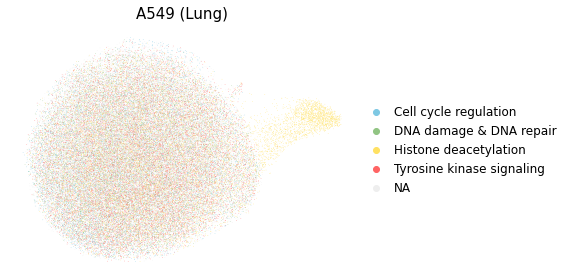

K562


/cs/labs/mornitzan/zoe.piran/venvzp/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


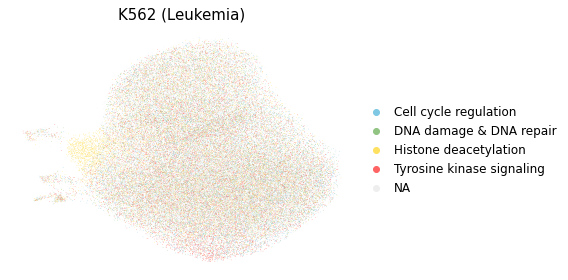

MCF7


/cs/labs/mornitzan/zoe.piran/venvzp/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


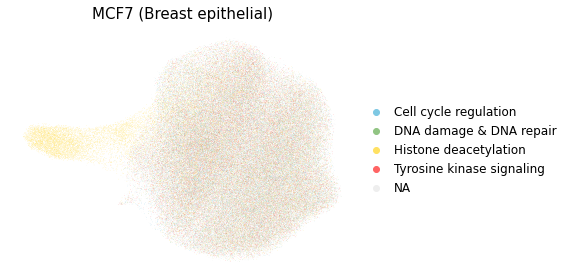

In [20]:
for cell_line in adata.obs["cell_type"].cat.categories:
    print(cell_line)
    adata_ = adata[adata.obs["cell_type"].isin([cell_line])].copy()
    sc.pp.neighbors(adata_)
    sc.tl.pca(adata_)
    sc.tl.umap(adata_)

    fig, axs = plt.subplots(1, 1, figsize=(8, 4))
    sc.pl.umap(
        adata_,
        color="pathway_groups",
        title=titles[cell_line],
        ax=axs,
        show=False,
    )
    # axs.set_title(key_)
    axs.set_axis_off()

    plt.tight_layout()
    plt.savefig(FIG_DIR_LCL + f"{cell_line}_pathways.png", format="png", dpi=300)
    plt.show()

In [21]:
adata.write(DATA_DIR_LCL + "sciplex3_biolord.h5ad")